<a href="https://colab.research.google.com/github/mlacasa/EstadisticaQ2/blob/main/Actividad1_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧪 Actividad ANOVA: estatinas y reducción del colesterol 💊📉

## 🧩 Contexto (historia clínica “realista”)
En una clínica se quiere comparar la eficacia de **3 estatinas** para reducir el **colesterol total (mg/dL)**:

- **Atorvastatina**
- **Simvastatina**
- **Rosuvastatina**

De cada paciente tenemos:
- una medición **basal** (antes de empezar)
- una medición **final** (tras el tratamiento)

Y además dos variables “de estilo de vida” que usaremos después:
- **Sexo**: `F / M`
- **Deporte**: si hace **≥ 2 horas/semana** → `Sí / No`

> 🎯 Tu misión: analizar si los tratamientos funcionan, cuál parece mejor, y si el deporte ayuda.

---

## 🗂️ Dataset: qué columnas debe tener
Mínimos recomendados (puedes añadir más si quieres):

- `id`
- `statin` (Atorva / Simva / Rosuva)
- `sex` (F/M)
- `sport` (Yes/No)
- `chol_baseline` (mg/dL)
- `chol_final` (mg/dL)

📌 Variable derivada útil (la crearás tú):
- `reduction = chol_baseline - chol_final`  
  ✅ si `reduction` es positiva → **mejora** (baja el colesterol)

---

## 🧭 Guion del análisis (tú decides algunos pasos)
### 1) 🔍 “Sanity check” de datos + supuestos
Antes de lanzarte:
- mira **valores raros** (mínimos/máximos), missing, tamaños por grupo
- evalúa **normalidad** (por grupo o del residuo del modelo)  
  🧠 *Elige tú*: Shapiro-Wilk, Q-Q plot, histograma…
- evalúa **homocedasticidad** (igualdad de varianzas)  
  ✅ *Sugerido*: **Levene**

⚠️ Importante: en **uno** de los análisis **no habrá homocedasticidad** (lo tendrás que detectar).  
👉 Cuando eso ocurra, **no uses ANOVA clásico**: aplica **ANOVA de Welch**.

---

### 2) 🟦 Comparación basal: ¿arrancan iguales los 3 grupos?
Queremos comprobar si los pacientes parten homogéneos:
- comparar `chol_baseline` entre las 3 estatinas con **ANOVA one-way**  
  🎯 Interpretación esperada: idealmente, **sin diferencias claras** al inicio.

> ✅ Aquí decides: ¿reportas también tamaño del efecto (η², ω², etc.)?

---

### 3) 🔁 Efectividad dentro de cada tratamiento (datos pareados)
Aquí miramos si **cada estatina** reduce el colesterol en sus propios pacientes:
- comparar `chol_baseline` vs `chol_final` **en los mismos sujetos** (pareado)

🧠 *Decisión del alumno*:
- Si asumes normalidad → **t pareada**
- Si no te convence → alternativa no paramétrica (opcional)  

🎯 Conclusión: ¿cada estatina funciona “por sí misma”?

---

### 4) 🏁 ¿Cuál estatina parece mejor?
Ahora toca comparar tratamientos entre sí.

🧠 *Decisión del alumno* (elige UNA variable respuesta):
- Opción A: comparar `chol_final`
- Opción B (muy recomendable): comparar `reduction`

Después:
- haz **ANOVA one-way** (o **Welch** si Levene falla)
- si el test global es significativo → **post-hoc Tukey HSD** para ver **qué pares** difieren.

---

### 5) 🧑‍🤝‍🧑 Two-way: ¿el deporte mejora el resultado?
Usaremos `reduction` como variable principal (recomendado) y analizaremos:
- efecto de `statin`
- efecto de `sport`
- (opcional) interacción `statin * sport`

🧠 *Decisión del alumno*:
- ¿incluyes interacción o te quedas en efectos principales?
- ¿cómo interpretas una interacción si aparece?

🎯 Pregunta final: **¿hacer deporte ≥2h/semana mejora la reducción?**  
¿y mejora igual con todas las estatinas?

---

## 📝 Entregable (en el propio Notebook)
Incluye, de forma breve y clara:
- qué test has usado en cada parte **y por qué** (ANOVA vs Welch, etc.)
- resultados clave (estadístico, p-valor; y si puedes, efecto)
- conclusión clínica en 3–5 líneas:  
  ✅ “qué estatina funciona mejor” + ✅ “si el deporte ayuda” + ✅ “matices/limitaciones”

💡 Consejo: comenta tus decisiones en Markdown (como si fuese un mini-informe).


In [1]:
# CELDA 1 — Librerías + creación de la dataset (sintética, reproducible)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.oneway import anova_oneway  # útil para ANOVA de Welch más adelante

# =========================
# 1) Parámetros (alumno)
# =========================
# TODO (alumno): cambia la semilla y comprueba si las conclusiones se mantienen
SEED = 123
rng = np.random.default_rng(SEED)

# TODO (alumno): prueba con diferentes tamaños muestrales (p.ej. 60, 90, 150)
n_total = 120

# =========================
# 2) Variables categóricas
# =========================
statins = np.array(["Atorvastatina", "Simvastatina", "Rosuvastatina"])
sexes   = np.array(["F", "M"])
sports  = np.array(["No", "Sí"])  # ≥2h/semana

statin = rng.choice(statins, size=n_total, p=[1/3, 1/3, 1/3])
sex    = rng.choice(sexes,   size=n_total, p=[0.55, 0.45])
sport  = rng.choice(sports,  size=n_total, p=[0.55, 0.45])

# =========================
# 3) Generación de colesterol
# =========================
# Basal: queremos que NO haya diferencias por estatina (grupos homogéneos al inicio)
# (pero sí permitimos efectos pequeños de sexo/deporte, realistas)
base_mean = 240
sex_effect_baseline   = {"F": -2.0, "M": +2.0}
sport_effect_baseline = {"No": +1.0, "Sí": -1.0}

chol_baseline = np.array([
    rng.normal(
        loc=base_mean + sex_effect_baseline[s] + sport_effect_baseline[sp],
        scale=20.0
    )
    for s, sp in zip(sex, sport)
])

# Reducción (mejora): aquí sí hay efecto del tratamiento + deporte.
# Además, forzamos heterocedasticidad entre estatinas (para que en algún punto Levene falle → Welch)
treat_effect_reduction = {"Atorvastatina": 30.0, "Simvastatina": 22.0, "Rosuvastatina": 35.0}
sport_effect_reduction = {"No": 0.0, "Sí": 6.0}
sex_effect_reduction   = {"F": 0.0, "M": 1.5}

# Diferente desviación típica por estatina (esto suele romper homocedasticidad en la comparación entre grupos)
treat_sd_reduction = {"Atorvastatina": 10.0, "Simvastatina": 18.0, "Rosuvastatina": 12.0}

reduction = np.array([
    rng.normal(
        loc=treat_effect_reduction[t] + sport_effect_reduction[sp] + sex_effect_reduction[s],
        scale=treat_sd_reduction[t]
    )
    for t, sp, s in zip(statin, sport, sex)
])

# Aseguramos que casi nadie "empeore" por puro ruido (si sale negativo, lo truncamos suavemente)
reduction = np.maximum(reduction, 0.0)

chol_final = chol_baseline - reduction

# Evitar valores fisiológicamente absurdos (solo por limpieza didáctica)
chol_final = np.clip(chol_final, 120, None)
reduction  = chol_baseline - chol_final  # recalculamos por coherencia tras el clip

# =========================
# 4) Dataset final
# =========================
df = pd.DataFrame({
    "id": np.arange(1, n_total + 1),
    "statin": statin,
    "sex": sex,
    "sport": sport,
    "chol_baseline": chol_baseline,
    "chol_final": chol_final,
    "reduction": reduction
})

# Vista rápida
display(df.head())

print("Tamaño dataset:", df.shape)
print("\nRecuento por estatina:")
display(df["statin"].value_counts())

print("\nRecuento por deporte:")
display(df["sport"].value_counts())


,id,statin,sex,sport,chol_baseline,chol_final,reduction
0,1,Rosuvastatina,M,Sí,229.628123,188.158868,41.469255
1,2,Atorvastatina,F,Sí,221.662364,185.828946,35.833418
2,3,Atorvastatina,M,No,216.576601,178.504907,38.071695
3,4,Atorvastatina,M,No,238.474330,211.836507,26.637824
4,5,Atorvastatina,F,No,242.128048,222.704953,19.423095


Tamaño dataset: (120, 7)

Recuento por estatina:


,count
statin,
Atorvastatina,45
Simvastatina,40
Rosuvastatina,35



Recuento por deporte:


,count
sport,
No,72
Sí,48


## 📌 Antes de empezar: descriptivos rápidos (tu “mini-check”)

🧠 **Prompt (hazlo tú):**  
Genera un bloque de código que muestre estadísticas descriptivas básicas de la dataset `df` para entender qué tienes entre manos.

✅ Debe incluir, como mínimo:
- Tamaño total (`n`) y número de pacientes por `statin`, `sex` y `sport`
- Para `chol_baseline`, `chol_final` y `reduction`:
  - media, desviación estándar, mediana, mínimo y máximo
- Los mismos descriptivos **por grupo de estatina** (y si quieres, también por `sport`)

💡 Pista: puedes usar `df.describe()` y `df.groupby(...).agg(...)`.

⬇️ **Debajo de este texto añade una celda de código** con tus descriptivos.


In [2]:
print(f"\nTotal de pacientes (n): {len(df)}")

print("\n--- Conteo por Estatina ---")
display(df['statin'].value_counts())

print("\n--- Conteo por Sexo ---")
display(df['sex'].value_counts())

print("\n--- Conteo por Deporte ---")
display(df['sport'].value_counts())

print("\n--- Descriptivos generales (chol_baseline, chol_final, reduction) ---")
display(df[['chol_baseline', 'chol_final', 'reduction']].describe().loc[['mean', 'std', '50%', 'min', 'max']])

print("\n--- Descriptivos por Estatina ---")
display(df.groupby('statin')[['chol_baseline', 'chol_final', 'reduction']].agg(['mean', 'std', 'median', 'min', 'max']))

print("\n--- Descriptivos por Deporte ---")
display(df.groupby('sport')[['chol_baseline', 'chol_final', 'reduction']].agg(['mean', 'std', 'median', 'min', 'max']))


Total de pacientes (n): 120

--- Conteo por Estatina ---


,count
statin,
Atorvastatina,45
Simvastatina,40
Rosuvastatina,35



--- Conteo por Sexo ---


,count
sex,
F,71
M,49



--- Conteo por Deporte ---


,count
sport,
No,72
Sí,48



--- Descriptivos generales (chol_baseline, chol_final, reduction) ---


,chol_baseline,chol_final,reduction
mean,237.941239,206.296181,31.645058
std,20.907686,24.724418,15.498627
50%,236.764429,205.162296,34.333041
min,177.034373,148.858792,0.000000
max,294.906116,261.853739,63.039767



--- Descriptivos por Estatina ---


chol_baseline                                                 \
                       mean        std      median         min         max   
statin                                                                       
Atorvastatina    241.774024  20.950019  240.897069  199.134178  285.656535   
Rosuvastatina    235.881579  21.917620  237.404341  177.034373  294.906116   
Simvastatina     235.431558  19.814794  234.244036  183.677592  280.527219   

               chol_final                                                 \
                     mean        std      median         min         max   
statin                                                                     
Atorvastatina  210.864564  23.379916  210.453761  150.968172  252.329273   
Rosuvastatina  194.124291  24.001161  192.788941  148.858792  261.853739   
Simvastatina   211.807153  23.625127  208.838207  157.867139  254.566258   

               reduction                                              
                    mean        std     median        min        max  
statin                                                                
Atorvastatina  30.909460  12.022080  32.140942   4.480303  51.344119  
Rosuvastatina  41.757288   9.722069  41.469255  21.738421  63.039767  
Simvastatina   23.624405  18.141275  22.878871   0.000000  61.223957


--- Descriptivos por Deporte ---


chol_baseline                                                 \
               mean        std      median         min         max   
sport                                                                
No       239.770415  21.864612  238.713458  177.034373  294.906116   
Sí       235.197475  19.281797  235.421911  183.677592  272.221302   

       chol_final                                                 reduction  \
             mean        std      median         min         max       mean   
sport                                                                         
No     209.829793  23.668253  207.885514  148.858792  261.853739  29.940621   
Sí     200.995762  25.567412  197.829715  150.968172  253.254872  34.201714   

                                             
             std     median  min        max  
sport                                        
No     14.423343  32.877361  0.0  54.965012  
Sí     16.816555  37.678244  0.0  63.039767

## 🧠 Nota importante (aquí mandas tú)

En esta actividad **no hay una única forma “correcta”** de hacer la parte descriptiva.  
Te interesa que el análisis sea **claro, razonado y replicable**.

✨ **Sé creativo/a**:
- prueba distintas tablas resumen (`groupby`, `pivot_table`)
- acompaña con algún gráfico útil (boxplots, histogramas por grupo, etc.)
- explica brevemente *qué te llama la atención* y *por qué*

📚 **Investiga**: si no recuerdas un comando, búscalo (documentación, apuntes, ejemplos).  
Lo importante es que se note que **entiendes qué estás comprobando**.

---

## ✅ Requisitos para aplicar ANOVA (comprobaciones previas)

Antes de correr un ANOVA, revisa al menos:

1) **Normalidad**  
- Comprueba si las distribuciones (o los residuos del modelo) son razonablemente normales.  
- Puedes usar Shapiro-Wilk, Q-Q plots, histogramas…  
🧠 *Decide tú qué evidencias te parecen suficientes.*

2) **Homocedasticidad (igualdad de varianzas)**  
- Comprueba si las varianzas entre grupos son similares.  
- Sugerido: **test de Levene**.

⚠️ **Aviso**: en algún punto del ejercicio, la homocedasticidad **no se cumplirá**.  
Tu trabajo es **detectarlo** y **adaptar el análisis** (por ejemplo, usando **ANOVA de Welch**).

⬇️ A continuación, crea una celda de código para evaluar **normalidad** y **homocedasticidad**  
(indica claramente qué variable estás evaluando y por qué).


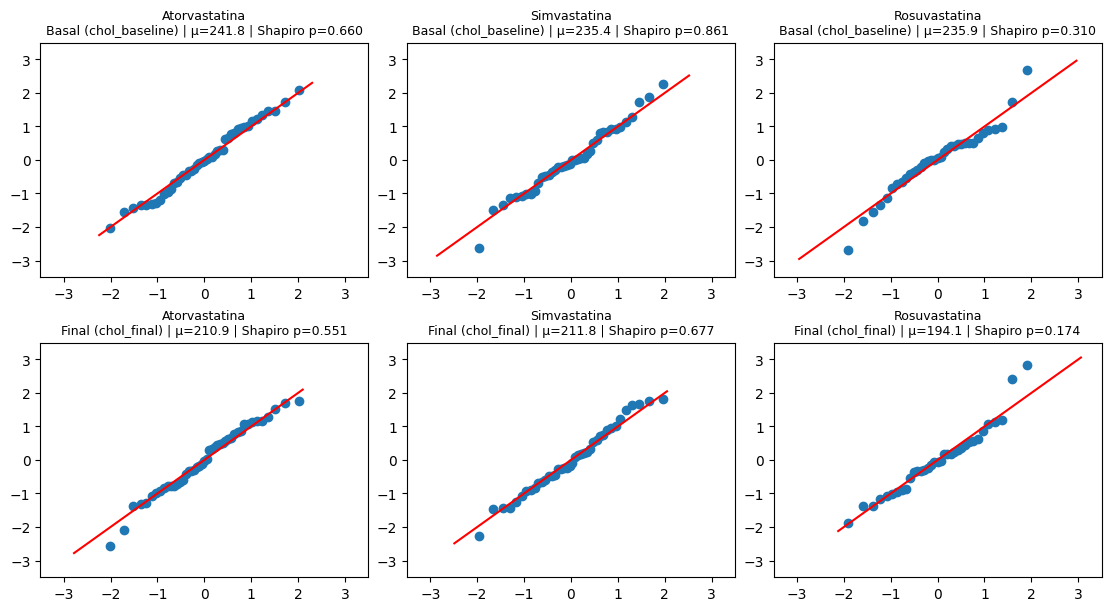

In [4]:
# CELDA — QQ-plots correctos (escala estandarizada) por estatina y momento (basal/final)
# En cada gráfico: nombre + media (mg/dL) + p-valor de Shapiro (sobre datos originales)

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

def shapiro_p(x):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) < 3 or np.allclose(x, x[0]):
        return np.nan
    return stats.shapiro(x).pvalue

def zscore(x):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    s = np.std(x, ddof=1)
    if len(x) < 3 or s == 0:
        return np.full_like(x, np.nan)
    return (x - np.mean(x)) / s

statin_order = ["Atorvastatina", "Simvastatina", "Rosuvastatina"]
measures = [("chol_baseline", "Basal"), ("chol_final", "Final")]

fig, axes = plt.subplots(
    nrows=len(measures), ncols=len(statin_order),
    figsize=(11, 6), constrained_layout=True
)

for r, (col, label) in enumerate(measures):
    for c, st in enumerate(statin_order):
        ax = axes[r, c]

        x_raw = df.loc[df["statin"] == st, col].dropna().values
        x_z = zscore(x_raw)

        # QQ plot en escala estándar (z), ahora sí tiene sentido la línea 45°
        sm.ProbPlot(x_z).qqplot(line="45", ax=ax)

        mu = np.mean(x_raw) if len(x_raw) else np.nan
        p  = shapiro_p(x_raw)

        ax.set_title(f"{st}\n{label} ({col}) | μ={mu:.1f} | Shapiro p={p:.3f}", fontsize=9)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xlim(-3.5, 3.5)
        ax.set_ylim(-3.5, 3.5)

plt.show()


## 2) 🟦 Comparación basal: ¿los grupos parten iguales?

Antes de evaluar si una estatina “funciona mejor”, debemos comprobar que los tres grupos **empiezan en condiciones comparables**.  
Para ello contrastamos si existen diferencias en `chol_baseline` entre:

- Atorvastatina
- Simvastatina
- Rosuvastatina

✅ **Hipótesis del ANOVA one-way**  
- **H0:** las medias basales son iguales en los 3 grupos  
- **H1:** al menos una media basal difiere

🔎 ¿Por qué es importante?  
Si en el basal ya hubiese diferencias claras, entonces comparar resultados finales podría ser engañoso (no sabríamos si las diferencias se deben al tratamiento o a que los grupos no eran homogéneos desde el inicio).

📌 En la celda de código siguiente:
1. Aplica un **ANOVA one-way** sobre `chol_baseline ~ statin`  
2. Reporta el estadístico, el p-valor y una breve conclusión (¿son homogéneos o no?)
3. Si detectas que no se cumple homocedasticidad, justifica el uso de **Welch**.


/tmp/ipython-input-4026512795.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=statin_order, showmeans=True)


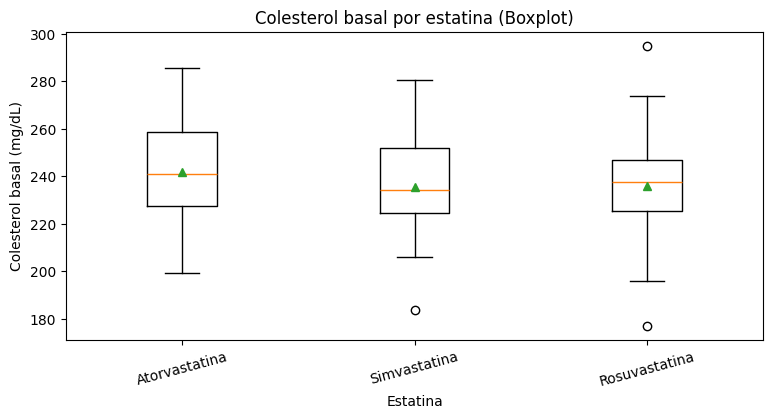

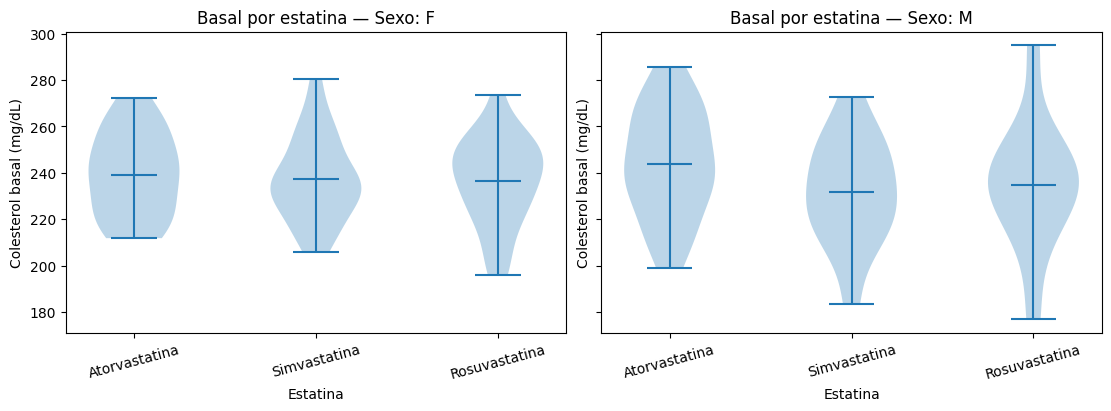

In [6]:
# CELDA — Visualización basal: boxplot por estatina + violin por estatina estratificado por sexo

import numpy as np
import matplotlib.pyplot as plt

statin_order = ["Atorvastatina", "Simvastatina", "Rosuvastatina"]

# --- 1) Boxplot: colesterol basal por estatina (orden controlado) ---
data_box = [
    df.loc[df["statin"] == st, "chol_baseline"].dropna().values
    for st in statin_order
]

plt.figure(figsize=(9, 4))
plt.boxplot(data_box, labels=statin_order, showmeans=True)
plt.title("Colesterol basal por estatina (Boxplot)")
plt.xlabel("Estatina")
plt.ylabel("Colesterol basal (mg/dL)")
plt.xticks(rotation=15)
plt.show()

# --- 2) Violin plot: colesterol basal por estatina, separado por sexo ---
fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True, constrained_layout=True)

for ax, sx in zip(axes, ["F", "M"]):
    data_violin = [
        df.loc[(df["statin"] == st) & (df["sex"] == sx), "chol_baseline"].dropna().values
        for st in statin_order
    ]

    ax.violinplot(data_violin, showmeans=True, showmedians=False, showextrema=True)
    ax.set_title(f"Basal por estatina — Sexo: {sx}")
    ax.set_xlabel("Estatina")
    ax.set_ylabel("Colesterol basal (mg/dL)")
    ax.set_xticks(np.arange(1, len(statin_order) + 1))
    ax.set_xticklabels(statin_order, rotation=15)

plt.show()


## ✅ Interpretación del ANOVA basal y siguiente paso (datos pareados)

Ahora toca ejecutar el **ANOVA one-way basal** (`chol_baseline ~ statin`) y **decidir** si hay diferencias significativas entre los grupos al inicio.

🧠 **Qué debes concluir:**
- Si el ANOVA basal **no es significativo** (p ≥ 0.05), la lectura es sencilla:  
  ✅ los grupos parten de forma **homogénea** → comparar tratamientos es más limpio.
- Si el ANOVA basal **sí es significativo** (p < 0.05), entonces hay un problema de comparabilidad:  
  ⚠️ los grupos **no arrancan iguales** y eso puede sesgar comparaciones posteriores (por ejemplo, en valores finales).  
  En ese caso, explica **por qué crees que ocurre** (azar muestral, desbalance por sexo/deporte, varianzas distintas, tamaño muestral, etc.) y qué implicaría.

📌 En la siguiente parte pasamos a la efectividad del tratamiento **dentro de cada paciente**, usando **datos pareados**:

## 🔁 Análisis pareado: ¿baja el colesterol con cada estatina?
Aquí ya no comparamos entre grupos al inicio, sino que preguntamos:
- ¿`chol_final` es menor que `chol_baseline` en los mismos sujetos?

➡️ Para ello, realiza un **test pareado** por estatina (p. ej. **t pareada**) y reporta:
- el p-valor
- la dirección del efecto (si baja o sube)
- y, si puedes, una medida de magnitud (media de la reducción, etc.)

⬇️ A continuación: celda de código con el ANOVA basal + (después) la comparación pareada por grupo.


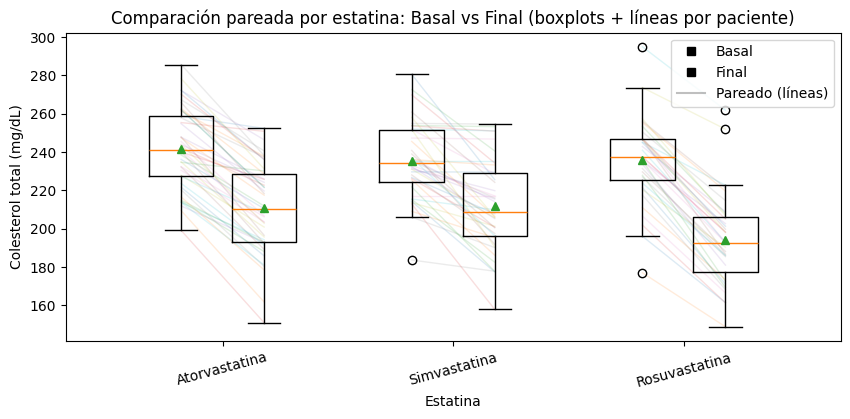

In [7]:
# CELDA — Boxplot “pareado” (Basal vs Final) para cada estatina en un único gráfico

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

statin_order = ["Atorvastatina", "Simvastatina", "Rosuvastatina"]

x = np.arange(len(statin_order))
offset = 0.18
pos_bas = x - offset
pos_fin = x + offset

data_bas = [df.loc[df["statin"] == st, "chol_baseline"].dropna().values for st in statin_order]
data_fin = [df.loc[df["statin"] == st, "chol_final"].dropna().values for st in statin_order]

plt.figure(figsize=(10, 4))

# (opcional pero muy visual) líneas finas conectando basal->final por paciente dentro de cada estatina
for i, st in enumerate(statin_order):
    sub = df.loc[df["statin"] == st, ["chol_baseline", "chol_final"]].dropna()
    for b, f in sub.to_numpy():
        plt.plot([pos_bas[i], pos_fin[i]], [b, f], alpha=0.15, linewidth=1)

# Boxplots
plt.boxplot(data_bas, positions=pos_bas, widths=0.28, showmeans=True)
plt.boxplot(data_fin, positions=pos_fin, widths=0.28, showmeans=True)

plt.xticks(x, statin_order, rotation=15)
plt.xlabel("Estatina")
plt.ylabel("Colesterol total (mg/dL)")
plt.title("Comparación pareada por estatina: Basal vs Final (boxplots + líneas por paciente)")

# Leyenda simple
plt.legend(
    handles=[
        Line2D([0], [0], color="black", lw=0, marker="s", label="Basal"),
        Line2D([0], [0], color="black", lw=0, marker="s", label="Final"),
        Line2D([0], [0], color="black", alpha=0.25, label="Pareado (líneas)")
    ],
    loc="best"
)

plt.show()


## ⭐ Parte clave: ¿qué estatina es la mejor? (ANOVA final + post-hoc)

Ahora viene el análisis central del ejercicio.

### 1) ANOVA one-way con datos finales
Debes comparar el colesterol **final** entre las tres estatinas:

- Variable respuesta: `chol_final`
- Factor: `statin`

✅ Hipótesis:
- **H0:** las medias finales son iguales en los 3 tratamientos
- **H1:** al menos una media final es distinta

📌 Importante:
- Antes de decidir el test, revisa **homocedasticidad** (Levene).  
  - Si **se cumple**, usa ANOVA clásico.  
  - Si **no se cumple**, justifica y aplica **ANOVA de Welch**.

### 2) Post-hoc: Tukey HSD
Si el contraste global (ANOVA/Welch) resulta significativo:
- aplica un **post-hoc Tukey HSD** para identificar **qué pares de estatinas** difieren.

### 3) Conclusión clínica (obligatoria)
Con tus resultados, responde en 3–5 líneas:

- ¿Qué estatina parece **mejor** (menor `chol_final`)?
- ¿Es una diferencia clara o depende del par comparado?
- Apoya tu respuesta con los resultados del **Tukey** (qué comparaciones son significativas).

⬇️ En la siguiente celda escribe el código y muestra:
- resultado del ANOVA (o Welch)
- tabla/resumen de Tukey
- tu conclusión final


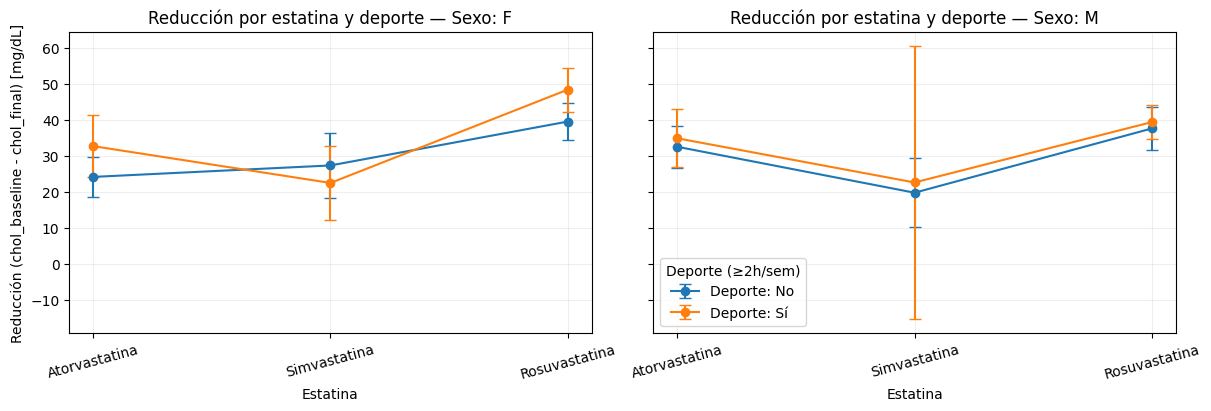

In [8]:
# CELDA — Ilustrar diferencias por sexo y deporte (variable respuesta: reducción)
# Gráfico recomendado: "interaction plot" en 2 paneles (F y M)

import numpy as np
import matplotlib.pyplot as plt

statin_order = ["Atorvastatina", "Simvastatina", "Rosuvastatina"]
sport_order  = ["No", "Sí"]

def mean_ci95(x):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)
    if n < 2:
        return np.nan, np.nan
    m = np.mean(x)
    se = np.std(x, ddof=1) / np.sqrt(n)
    ci = 1.96 * se
    return m, ci

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)

for ax, sx in zip(axes, ["F", "M"]):
    for sp in sport_order:
        means = []
        cis = []
        for st in statin_order:
            vals = df.loc[(df["sex"] == sx) & (df["sport"] == sp) & (df["statin"] == st), "reduction"].values
            m, ci = mean_ci95(vals)
            means.append(m)
            cis.append(ci)

        ax.errorbar(
            np.arange(len(statin_order)),
            means,
            yerr=cis,
            marker="o",
            linestyle="-",
            capsize=4,
            label=f"Deporte: {sp}"
        )

    ax.set_title(f"Reducción por estatina y deporte — Sexo: {sx}")
    ax.set_xticks(np.arange(len(statin_order)))
    ax.set_xticklabels(statin_order, rotation=15)
    ax.set_xlabel("Estatina")
    ax.grid(True, alpha=0.2)

axes[0].set_ylabel("Reducción (chol_baseline - chol_final) [mg/dL]")
axes[1].legend(title="Deporte (≥2h/sem)")

plt.show()


## 🧩 Último paso: ANOVA two-way (¡tu turno!)

Ahora vas a comprobar, de forma **formal**, si variables del paciente influyen en la eficacia del tratamiento.

🎯 **Pregunta principal**  
¿La reducción de colesterol (`reduction`) depende de:
- **Sexo** (`sex`)
- **Deporte** (`sport`)
y/o de su combinación con la estatina?

### ✅ Qué modelo se espera
Plantea un **ANOVA two-way** con:
- Variable respuesta: `reduction`
- Factores: `statin`, `sex`, `sport`

🧠 Decisiones que debes tomar (y justificar brevemente):
- ¿Incluyes interacciones? (recomendado explorar al menos `statin*sport` y/o `statin*sex`)
- Si una interacción es significativa: ¿qué significa en términos clínicos?

📌 Pista (no te lo dejo hecho): en `statsmodels` puedes usar fórmulas del tipo:  
`reduction ~ statin + sex + sport`  
o  
`reduction ~ statin * sport + statin * sex`  
(recuerda que `*` incluye también el efecto principal + interacción).

---

## 💪 Cierre (lo que ya sabes hacer)
Cuando termines esta parte, habrás practicado competencias clave:

✅ Preparación y exploración descriptiva de datos biomédicos  
✅ Verificación de supuestos (normalidad / homocedasticidad) y elección del test adecuado (ANOVA vs Welch)  
✅ Comparación basal para validar grupos homogéneos  
✅ Análisis de datos pareados (pre vs post) para evaluar eficacia dentro de sujeto  
✅ Comparación entre tratamientos + post-hoc Tukey para decidir “qué tratamiento es mejor”  
✅ Modelos multifactoriales (two-way) para evaluar el papel del sexo y del deporte

🚀 ¡Ánimo! Si algo no sale a la primera, es normal: revisa el output, ajusta el modelo y explica tus decisiones.
Lo importante no es “sacar un p-valor”, sino **razonar el análisis** como lo harías en un informe real.
